### RandomizedSearchCV にリトライ、ImageDataGenerator/model.fit で実行


In [4]:
import os
import re
import datetime
import random
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')


def generate_data(x, t, num=5):
  datagen = ImageDataGenerator(
    #rotation_range=180,     # randomly rotate images in the range
    zoom_range=0.2,         # randomly zoom image
    width_shift_range=0.2,  # randomly shift images horizontally
    height_shift_range=0.2, # randomly shift images vertically
    horizontal_flip=True,   # randomly flip images horizontally
    #vertical_flip=True      # randomly flip images vertically
  )

  x_list = []
  t_list = []

  x_array = np.expand_dims(x, axis=0)

  datagen.fit(x_array)

  iter = datagen.flow(x_array, batch_size=1)

  for i in range(num):
    ret = iter.next()
    #print(ret.shape, ret.dtype)
    x_list.append(ret[0])
    t_list.append(t)

  return x_list, t_list


def prepare_data(gen_num=5):
  x, t = [], []

  categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

  for dir_path in categorized_dir_paths:
    category_id = os.path.basename(dir_path)
    image_paths = glob(os.path.join(dir_path, '*'))
    print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

    for i, p in enumerate(image_paths):
      book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

      if i % 30 == 0:
          print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

      try:
          img = Image.open(p)
          img_resize = img.resize((229, 229))
          img_np = np.array(img_resize) / 255.0

          x.append(img_np)
          t.append(category_id)

          x_gen, t_gen = generate_data(img_np, category_id, gen_num)
          x.extend(x_gen)
          t.extend(t_gen)

      except Exception as e:
          print(datetime.datetime.now().isoformat(), 'Error:', e)

  return x, t


def reset_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

reset_seed(0)


x, t = prepare_data(5)
print(len(x), len(t))

x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)
print(x_train.shape, x_val.shape)

category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2020-06-18T03:15:35.699350 Category 0 : 117
2020-06-18T03:15:35.699886 Image: 0 1015 0
2020-06-18T03:15:37.356543 Image: 30 1228 0
2020-06-18T03:15:39.011270 Image: 60 1106 0
2020-06-18T03:15:40.644299 Image: 90 1129 0
2020-06-18T03:15:42.156877 Category 1 : 119
2020-06-18T03:15:42.157481 Image: 0 3636 1
2020-06-18T03:15:43.772590 Image: 30 3722 1
2020-06-18T03:15:45.409655 Image: 60 3832 1
2020-06-18T03:15:47.050455 Image: 90 3777 1
2020-06-18T03:15:48.612432 Category 2 : 129
2020-06-18T03:15:48.613122 Image: 0 3601 2
2020-06-18T03:15:50.240653 Image: 30 3884 2
2020-06-18T03:15:51.864992 Image: 60 3778 2
2020-06-18T03:15:53.539004 Image: 90 3853 2
2020-06-18T03:15:55.185945 Image: 120 1502 2
2020-06-18T03:15:55.677942 Category 3 : 111
2020-06-18T03:15:55.678873 Image: 0 3312 3
2020-06-18T03:15:57.360633 Image: 30 2350 3
2020-06-18T03:15:59.001294 Image: 60 3

In [ ]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

for layer in model_fine.layers[:100]:
    layer.trainable = False

model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(category_count, activation='softmax'))

optimizer = keras.optimizers.Adagrad(lr=0.005)
#optimizer = keras.optimizers.Adam(lr=0.005)
#optimizer = keras.optimizers.SGD(lr=0.005)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=100,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')

2020-06-16T13:50:54.022885 Start
2020-06-16T14:52:02.297366 End


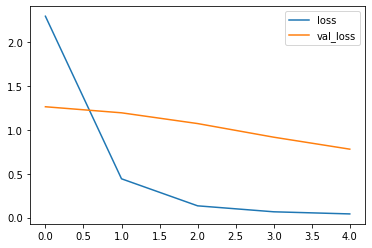

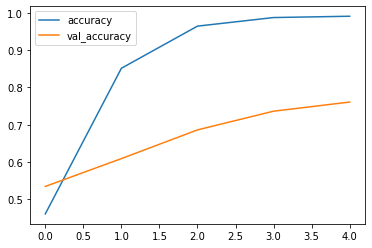

In [ ]:
results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

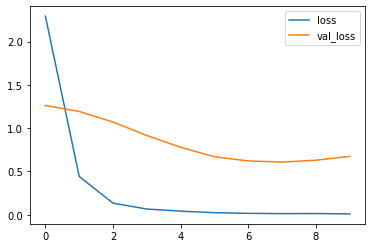

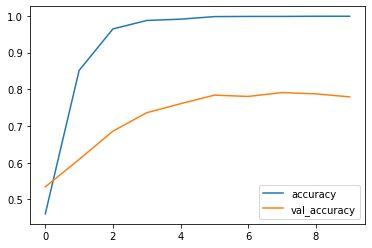

In [ ]:
results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

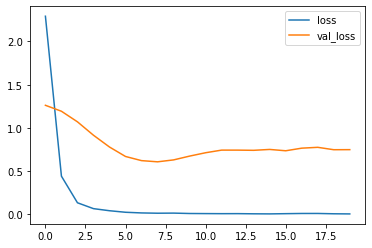

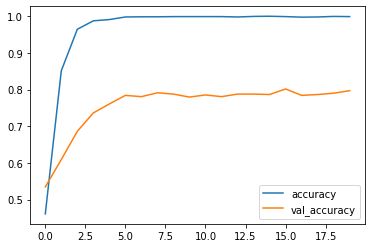

In [ ]:
results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

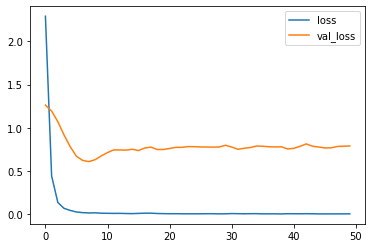

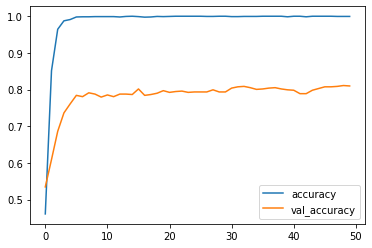

In [ ]:
results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

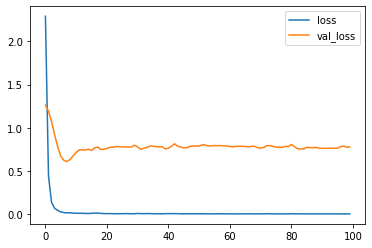

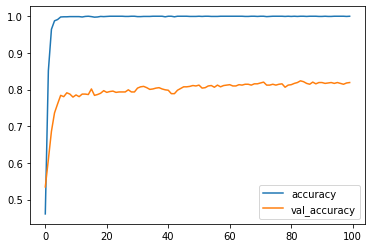

In [ ]:
results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

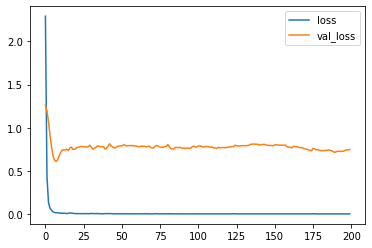

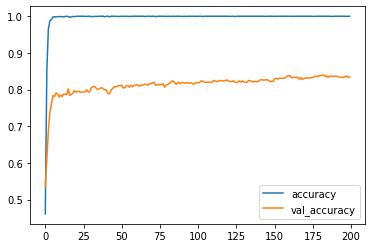

In [ ]:
results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

In [ ]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
195,0.000320,1.0000,0.727998,0.833139
196,0.000588,1.0000,0.737440,0.835473
197,0.000989,0.9995,0.740528,0.836639
198,0.000459,1.0000,0.745573,0.833139
199,0.000368,1.0000,0.746608,0.834306


2020-06-17T05:05:54.217356 Start
2020-06-17T06:05:30.463646 End


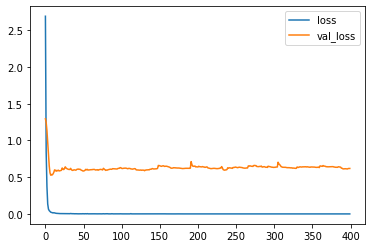

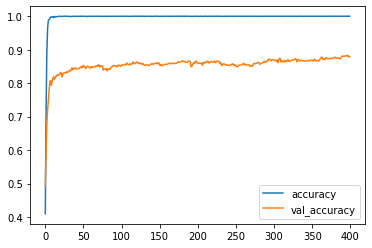

In [ ]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

for layer in model_fine.layers[:100]:
    layer.trainable = False

model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(category_count, activation='softmax'))

optimizer = keras.optimizers.Adagrad(lr=0.005)
#optimizer = keras.optimizers.Adam(lr=0.005)
#optimizer = keras.optimizers.SGD(lr=0.005)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=400,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')


results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

2020-06-17T06:35:04.304950 Start
2020-06-17T07:34:21.496101 End


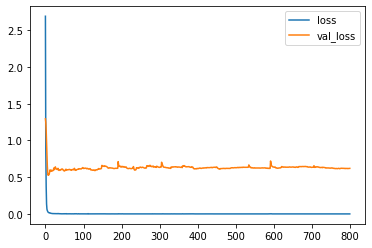

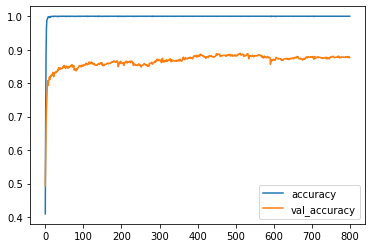

In [ ]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=400,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

In [ ]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
795,0.000424,0.9995,0.618005,0.876313
796,0.000074,1.0000,0.617234,0.879813
797,0.000057,1.0000,0.618091,0.878646
798,0.000028,1.0000,0.619702,0.878646
799,0.000134,1.0000,0.619825,0.876313


2020-06-17T07:47:47.487251 Start
2020-06-17T08:47:01.960644 End


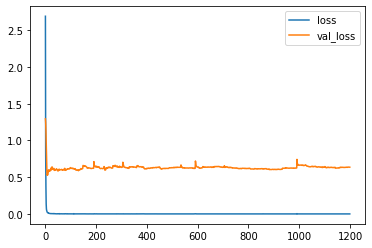

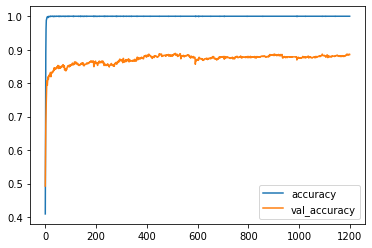

In [ ]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=400,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

In [ ]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
1195,0.000042,1.0,0.635892,0.884481
1196,0.000033,1.0,0.635258,0.884481
1197,0.000115,1.0,0.635606,0.886814
1198,0.000032,1.0,0.635454,0.885648
1199,0.000035,1.0,0.635767,0.885648


2020-06-17T08:48:43.100265 Start
2020-06-17T10:47:08.432675 End


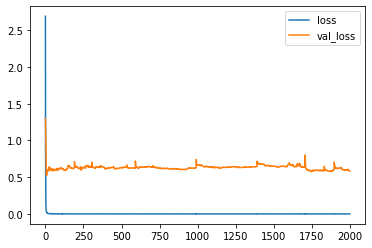

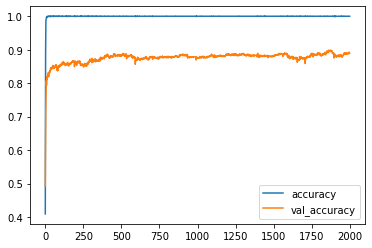

In [ ]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=800,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

In [ ]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
1995,0.000055,1.0,0.588849,0.892649
1996,0.000079,1.0,0.586529,0.891482
1997,0.000089,1.0,0.587623,0.890315
1998,0.000059,1.0,0.585820,0.890315
1999,0.000023,1.0,0.585419,0.889148


2020-06-17T10:48:32.647234 Start
2020-06-17T12:02:34.803419 End


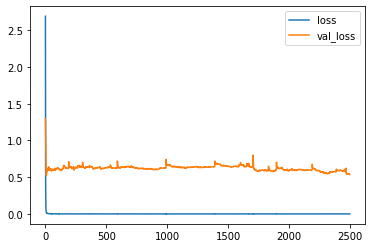

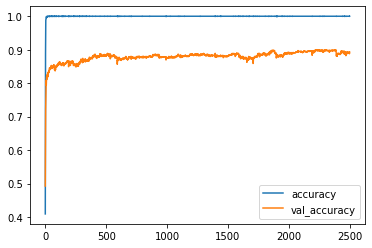

In [ ]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=500,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

In [ ]:
results.tail()

,loss,accuracy,val_loss,val_accuracy
2495,0.000057,1.0000,0.542113,0.890315
2496,0.000020,1.0000,0.544443,0.891482
2497,0.000102,1.0000,0.544741,0.887981
2498,0.000509,0.9995,0.541224,0.891482
2499,0.000368,1.0000,0.536215,0.892649


2020-06-17T12:03:16.701703 Start
2020-06-17T13:17:14.838672 End


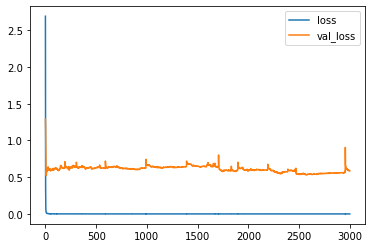

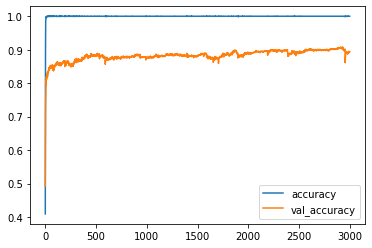

In [ ]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=500,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

### Adam に変更

83689472/83683744 [==============================] - 1s 0us/step
2020-06-18T02:43:27.022383 Start
2020-06-18T02:51:01.107451 End


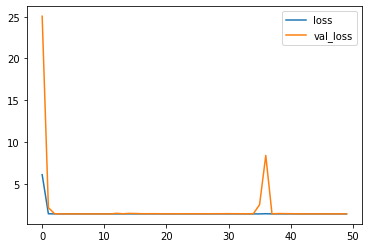

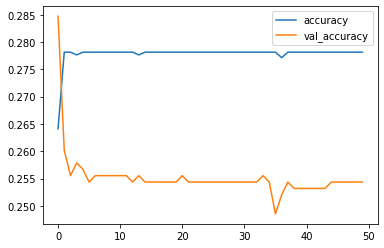

In [2]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

for layer in model_fine.layers[:100]:
    layer.trainable = False

model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(category_count, activation='softmax'))

#optimizer = keras.optimizers.Adagrad(lr=0.005)
optimizer = keras.optimizers.Adam(lr=0.005)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=50,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')


results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

2020-06-18T03:07:32.264258 Start
2020-06-18T03:14:55.663657 End


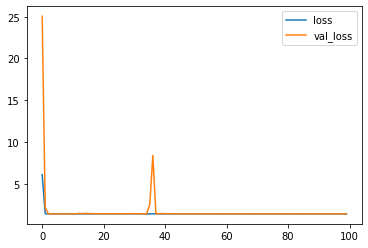

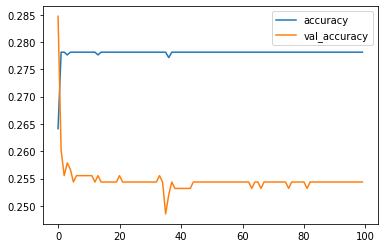

In [3]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=50,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

2020-06-18T03:16:44.546370 Start
2020-06-18T03:24:12.739647 End


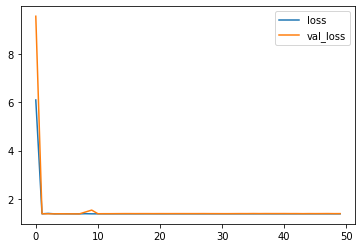

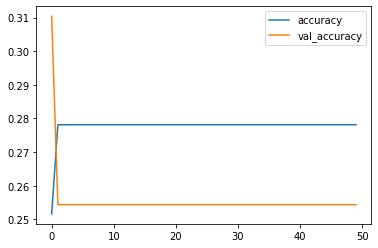

In [5]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

for layer in model_fine.layers[:100]:
    layer.trainable = False

model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(category_count, activation='softmax'))

#optimizer = keras.optimizers.Adagrad(lr=0.005)
optimizer = keras.optimizers.Adam(lr=0.005)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=50,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')


results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

2020-06-18T03:31:18.164853 Start
2020-06-18T03:53:33.259803 End


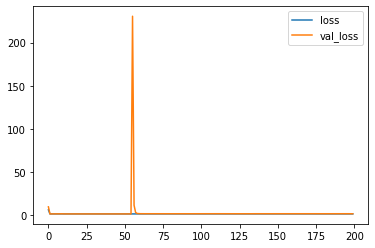

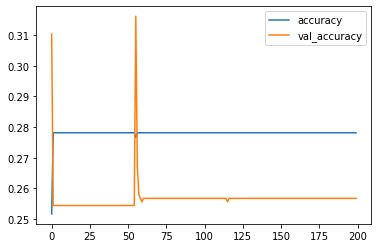

In [6]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=150,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')

results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

2020-06-18T03:54:52.347333 Start
2020-06-18T03:56:24.757357 End


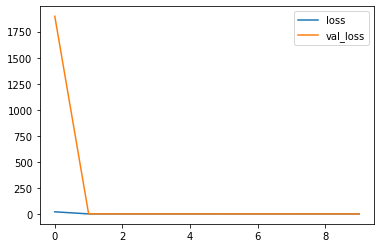

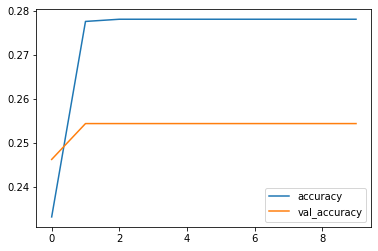

In [7]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

for layer in model_fine.layers[:100]:
    layer.trainable = False

model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(category_count, activation='softmax'))

#optimizer = keras.optimizers.Adagrad(lr=0.005)
optimizer = keras.optimizers.Adam(lr=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=10,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')


results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

2020-06-18T03:57:47.470170 Start
2020-06-18T03:59:19.142336 End


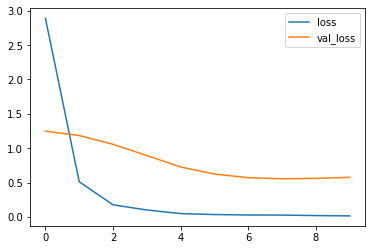

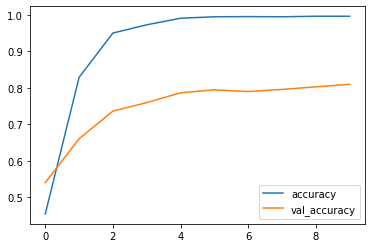

In [8]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

for layer in model_fine.layers[:100]:
    layer.trainable = False

model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(category_count, activation='softmax'))

optimizer = keras.optimizers.Adagrad(lr=0.005)
#optimizer = keras.optimizers.Adam(lr=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit(
    x_train,
    t_train,
    batch_size=32,
    epochs=10,
    verbose=0,
    validation_data=(x_val, t_val)
)

print(datetime.datetime.now().isoformat(), 'End')


results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()